In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [201]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from geopy.distance import distance

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


# 2. Load Data

In [6]:
data = pd.read_csv('../Dataset/tips.csv')
data

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


# 3. Initial Analysis

### 3.1. Metadata

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [9]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_bill,244.0,19.785943,8.902412,3.07,13.3475,17.795,24.1275,50.81
tip,244.0,2.998279,1.383638,1.00,2.0000,2.900,3.5625,10.00
size,244.0,2.569672,0.951100,1.00,2.0000,2.000,3.0000,6.00


In [10]:
print(data.isnull().sum())

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64


In [15]:
data['time'].value_counts()

Dinner    176
Lunch      68
Name: time, dtype: int64

### 3.2. Columns Processing

In [17]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']

categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']

print(f'Numerical Columns Train   : {numerical_columns}')
print(f'Categorical Columns Train : {categorical_columns}')

Numerical Columns Train   : ['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size']
Categorical Columns Train : []


In [16]:
le =  LabelEncoder()

data['sex'] = le.fit_transform(data['sex'])
data['smoker'] = le.fit_transform(data['smoker'])
data['day'] = le.fit_transform(data['day'])
data['time'] = le.fit_transform(data['time'])

# 4. EDA

Text(0.5, 1.0, 'Correlation Matrix')

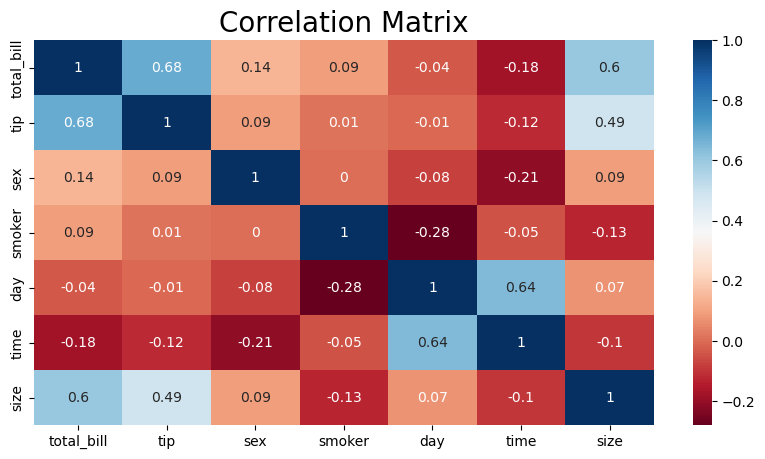

In [18]:
corr_data = data.corr().round(2)

plt.figure(figsize=(10, 5))
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 5. Regression Algoritms

In [56]:
X = data.drop(columns=['tip'])
Y = data['tip']

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(195, 6)
(49, 6)


In [92]:
adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradientBoosting = HistGradientBoostingRegressor()
XGB = XGBRegressor(n_jobs = -1)
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)

model = StackingRegressor([
    ('bagging', bagging),
    # ('extraTrees', extraTrees),
    # ('randomforest', randomForest),
    # ('decisionTree', decisionTree),
    # ('adaboost', adaboost),
    # ('gradient', gradient),
    # ('histGradientBoosting', histGradientBoosting),
    # ('XGB', XGB),
    # ('knn', knn),

], n_jobs=-1)

In [93]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('bagging', BaggingRegressor(n_jobs=-1))],
                  n_jobs=-1)

In [94]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

Train Score        : 83.17 %
Test Score         : 32.02 %
R Squared Error    : 0.32
Mean Squared Error : 0.85


In [95]:
train_predictions = model.predict(X_test).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

     Train Predictions  Actuals      Diff
24            2.557448     3.18  0.622552
6             2.176343     2.00  0.176343
153           3.749832     2.00  1.749832
211           3.278767     5.16  1.881233
198           2.153444     2.00  0.153444
38.54902734622862 / 49


In [26]:
print(train_results['Diff'].mean())

0.7984683310069471


# 6. Neural Network

In [265]:
X = data.drop(columns=['tip'])
Y = data['tip']

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True)
# scalar = MinMaxScaler(feature_range=(0,1))
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
X_val = scalar.fit_transform(X_val)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(170, 6)
(49, 6)
(25, 6)


In [288]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    # model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True,  input_shape = (X_train.shape[1],1)))
    # model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

# model = DNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001)
opt = Adam(learning_rate = 0.0001)

# model.compile(loss='mse', optimizer=opt, metrics=['mse'])
model.compile(loss='mean_squared_error', optimizer = opt)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_34 (GRU)                (None, 128)               50304     
                                                                 
 dense_64 (Dense)            (None, 1)                 129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


In [291]:
num_epoch = 100
batch_size = 32

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, epochs = num_epoch,
                    validation_data = [X_val, y_val], shuffle=False, verbose = 1,
                    # callbacks = [reduce_lr]
                    )

Epoch 1/100
6/6 [==============================] - 0s 15ms/step - loss: 1.2095 - val_loss: 0.7364
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 1.2079 - val_loss: 0.7357
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 1.2063 - val_loss: 0.7351
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 1.2047 - val_loss: 0.7344
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 1.2031 - val_loss: 0.7338
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 1.2016 - val_loss: 0.7332
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 1.2000 - val_loss: 0.7326
Epoch 8/100
6/6 [==============================] - 0s 8ms/step - loss: 1.1985 - val_loss: 0.7321
Epoch 9/100
6/6 [==============================] - 0s 8ms/step - loss: 1.1970 - val_loss: 0.7315
Epoch 10/100
6/6 [==============================] - 0s 8ms/step - loss: 1.1955 - val_loss: 0.7310
Epoch 11/100
6/6 [=======

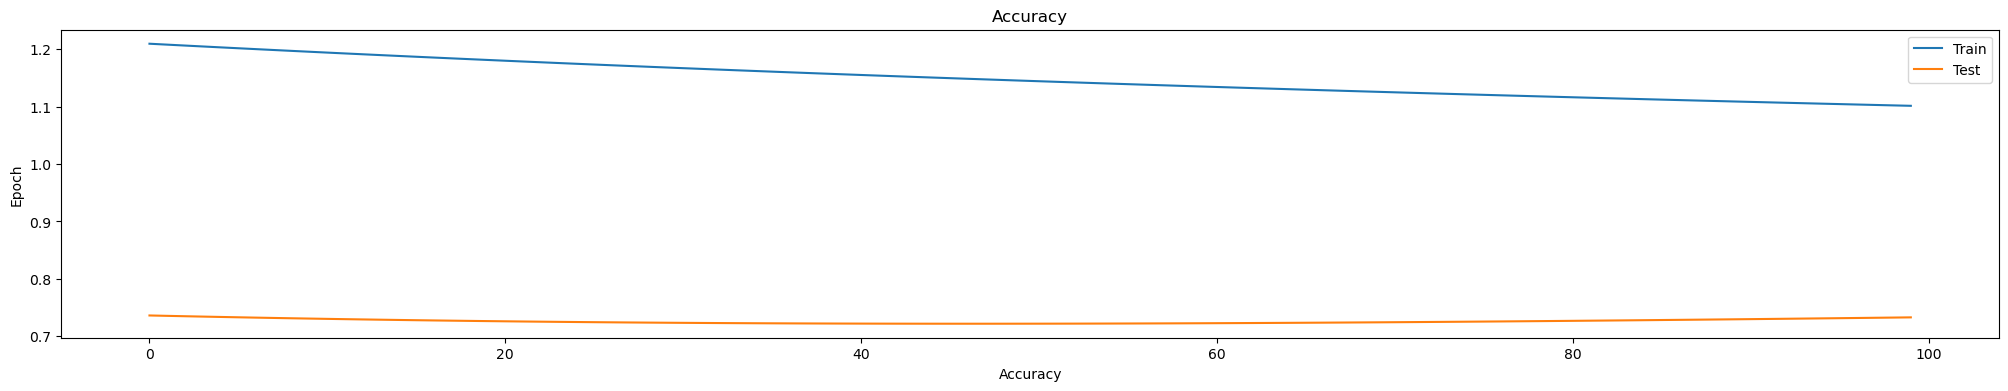

In [292]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [252]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

R Squared Error    : 0.16
Mean Squared Error : 2.29


In [253]:
train_predictions = model.predict(X_test).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].mean(), '-', (train_results['Diff'].sum()))

2/2 [==============================] - 0s 2ms/step
     Train Predictions  Actuals      Diff
91            3.104571     3.50  0.395429
90            3.453311     3.00  0.453311
92            2.499350     1.00  1.499350
179           3.565064     3.55  0.015064
75            2.908257     1.25  1.658257
1.0950162478855678 - 53.655796146392824


In [244]:
pred_df = data.copy()

x_test = pred_df.drop(columns=['tip'])
train_predictions = model.predict(x_test).flatten()

pred_df['Prediction'] = train_predictions
pred_df


8/8 [==============================] - 0s 3ms/step


,total_bill,tip,sex,smoker,day,time,size,Prediction
0,16.99,1.01,0,0,2,0,2,2.743862
1,10.34,1.66,1,0,2,0,3,2.043997
2,21.01,3.50,1,0,2,0,3,3.325841
3,23.68,3.31,1,0,2,0,2,3.387666
4,24.59,3.61,0,0,2,0,4,3.787393
...,...,...,...,...,...,...,...,...
239,29.03,5.92,1,0,1,0,3,3.886608
240,27.18,2.00,0,1,1,0,2,3.625041
241,22.67,2.00,1,1,1,0,2,3.268810
242,17.82,1.75,1,0,1,0,2,2.781403
